<div align="center">
    <H1>
        <Strong>
            Analysis on Hero Compositions in Overwatch
        </Strong>
    </H1>
    Chinhnam Nguyen, Jared Fleming, Ben Fleming
</div>

---

<div align="center">
    <H1>
        <Strong>
            Introduction
        </Strong>
    </H1>
</div>

Overwatch is a multiplayer team-based first-person shooter developed and published by Blizzard Entertainment and published in 2016. It skyrocketed in popularity quickly after release and is still going strong with over 5 million average players each month in 2021, and peaking as high as 7.3 million. Described as a "hero shooter", Overwatch assigns players into two teams of six, with each player selecting from a large roster of characters, known as "heroes", with unique abilities. Teams work to complete map-specific objectives within a limited period of time such as pushing a payload across the map or holding an area longer than the other team.

The meteoric rise in popularity also inspired both Blizzard and esports organizations to arrange their own teams and tournaments, resulting in the Overwatch League, which is produced and regulated by Blizzard themselves. Though based in the U.S., the league also features teams from Asia and Europe, resulting in 20 city-based teams, each with a max roster of 12 players. Due to its wide interchangeability between maps, gamemodes, and hero compositions (the heroes picked by each team), Overwatch is one of the most analyzed competitive games in the world. To help with this, Blizzard compiles and publicly releases the data collected throughout professional play during the year. All of the datasets can be accessed [here](https://overwatchleague.com/en-us/statslab "Overwatch League Stats Lab").

Here, we will be focusing on the data collected during the 2020 Overwatch League season, and will primarily intend to figure out the most optimal hero compositions for each map and gamemode. Heroes are meant to compliment and check each other as they are split into four classes: offense, defense, support, and tank. Obviously, we would expect a team of six attack heroes to succeed in aggressing the enemy, but would also expect them to fail miserably when defending an area. This is why finding a correct and balanced composition is integral to the game, and professional play in general.

---

<div align="center">
    <H1>
        <Strong>
            Exploring the Dataset
        </Strong>
    </H1>
</div>

We will be utilizing Python 3 along with various data science libraries: [pandas](https://pandas.pydata.org/), [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<H2>
    <Strong>
        Preprocessing the Data
    </Strong>
</H2>

Blizzard released the data for 2020 in two files, one for the first half and the other for the second half, due to its immense size (over 1.2 million rows). The dataset comes in the form of a CSV file.

In [10]:
# Reading in both datasets and combine into one dataframe
players1, players2 = pd.read_csv("phs_2020/phs_2020_1.csv"), pd.read_csv("phs_2020/phs_2020_2.csv")
data = pd.concat([players1, players2])
data.head()

,start_time,esports_match_id,tournament_title,map_type,map_name,player_name,team_name,stat_name,hero_name,stat_amount
0,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,All Damage Done,All Heroes,6674.164055
1,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Assists,All Heroes,11.000000
2,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Average Time Alive,All Heroes,60.199502
3,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Barrier Damage Done,All Heroes,1875.000000
4,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Damage Blocked,All Heroes,14640.911780


We can see that the raw dataset present us with a myriad of problems. Firstly, it includes data collected outside of the OWL 2020 Regular Season, which we will not be considering. Another issue is that `stat_name` is presented as it's own column instead of their own individual and respective columns. This will make it difficult for us to understand and view the dataset as well as accessing player statistics. We will be dropping the `start_time` column as it is irrelevant to what we are depicting, along with all rows that record the cumulative statistics for a player on all heroes (`hero_name == All Heroes`), since we are looking to compare individual hero statistics. The dataset also includes a multitude of irrelevant statistics that we will need to remove, such as `Environmental Kills` i.e. number of times the player knocks an enemy off of the map. To recap, there are five things we need to do to sanitize the data:
1. Drop all non OWL 2020 Regular Season rows
2. Pivot the table to turn stat_name into columns with stat_amount as values
3. Drop `start_time`
4. Drop all `hero_name == All Heroes` rows
5. Drop all irrelevant statistics

<H2>
    <Strong>
        Tidying the Dataset
    </Strong>
</H2>

In [8]:
# Drop irrelevant columns and rows
data.drop(['start_time'], axis=1)
data.drop(data.index[data['tournament_title'] != 'OWL 2020 Regular Season'], inplace=True)
data.drop(['tournament_title'], axis = 1, inplace = True)
data = data.reindex(columns = ['esports_match_id', 'map_type', 'map_name', 'player_name', 'team_name', 'hero_name', 'stat_name', 'stat_amount'])
data = data[data["hero_name"] != "All Heroes"]
stats = ['Hero Damage Done', 'Assists', 'Barrier Damage Done', 'Deaths', 'Eliminations', 'Objective Kills', 'Objective Time', 'Ultimates Earned - Fractional', 'Final Blows', 'Damage Blocked', 'Healing Done', 'All Damage Done']
data = data.loc[data['stat_name'].isin(stats)]
data['stat_amount'] = data['stat_amount'].round(decimals = 2)

# Tidy dataset to elongate stat_name column into rows and insert respective stat_amount values
data = data[['stat_name', 'stat_amount', 'player_name','esports_match_id','hero_name','map_name', 'team_name']].copy().reset_index()
data = data.pivot_table(values='stat_amount', index=[data['esports_match_id'],data['team_name'], data['player_name'], data['map_name'], data['hero_name']], columns='stat_name', aggfunc='sum')
data = data.fillna(0).reset_index()
data.rename(columns = {'Ultimates Earned - Fractional':'Ultimates Earned', 'esports_match_id':'match_id'}, inplace = True)
data['map_name'].replace({'King\'s Row': 'Kings Row'}, inplace = True)
data.head()

stat_name,match_id,team_name,player_name,map_name,hero_name,All Damage Done,Assists,Barrier Damage Done,Damage Blocked,Deaths,Eliminations,Final Blows,Healing Done,Hero Damage Done,Objective Kills,Objective Time,Ultimates Earned
0,30991,Paris Eternal,BenBest,Eichenwalde,Reinhardt,14495.63,10.0,5517.72,32655.81,9.0,19.0,9.0,0.00,8976.92,10.0,295.96,7.97
1,30991,Paris Eternal,BenBest,Havana,Reinhardt,9921.49,6.0,3075.00,21137.18,11.0,10.0,4.0,0.00,6837.43,3.0,148.89,5.15
2,30991,Paris Eternal,BenBest,Horizon Lunar Colony,Reinhardt,12362.02,13.0,3236.46,19394.67,10.0,21.0,8.0,0.00,8945.56,8.0,114.43,6.52
3,30991,Paris Eternal,BenBest,Lijiang Tower,Reinhardt,6674.16,11.0,1875.00,14640.91,5.0,13.0,2.0,0.00,4798.16,9.0,65.05,3.71
4,30991,Paris Eternal,FDGod,Eichenwalde,Lúcio,12012.14,14.0,5175.00,0.00,9.0,18.0,2.0,9229.73,6836.14,9.0,167.42,7.03


Here, we can see that the finalized dataset we will be analyzing has five objective columns and eleven stat columns.  
<Strong>Objective Columns:</Strong>
* `match_id` - The number referencing the matches in which the player earned the stats. A series of matches will have the same match_id.
* `team_name` - Name of the team of the player.
* `player_name` - In-game name of the player.
* `map_name` - Names of the maps on which the games were played.
* `hero_name` - Names of the heroes that the player played as.

<Strong>Stat Columns:</Strong>
* `All Damage Done` - Total damage done by the player in the match.
* `Assists` - Enemy deaths that the player participated in but did not achieve the final blow.
* `Barrier Damage Done` - Damage done by player only to enemy barriers.
* `Damage Blocked` - Damage blocked by the player's barriers (will only apply to barrier heroes).
* `Deaths` - Total death count of the player.
* `Eliminations` - Total number of enemy deaths that the player participated in.
* `Final Blows` - Enemy deaths in which the player achieved the final blow.
* `Healing Done` - Total personal and team health points healed by the player (will only apply to healer heroes).
* `Hero Damage Done` - Damage done only to enemy heroes.
* `Objective Kills` - Eliminations made by the player where the enemy was either at the objective point, or the player was defending the objective point.
* `Objective Time` - Time spent by the player either defending or attacking the objective point.
* `Ultimates Earned` - Total ultimate abilities earned by the player.

---

<div align="center">
    <H1>
        Exploratory Data Analysis
    </H1>
</div>

In [4]:
# Ignore map and average stats and prepare to plot efficiencies of each team per class
average_table = data.drop('map_name', axis=1, inplace=False)
average_table = average_table.groupby(['match_id', 'team_name', 'player_name', 'hero_name']).mean().reset_index()

teams = average_table['team_name'].unique()
healers = ['Lúcio', 'Baptiste', 'Moira', 'Ana', 'Zenyatta', 'Mercy', 'Brigitte', 'Soldier: 76']
tanks = ['Reinhardt', 'Mei', 'Orisa', 'Symmetra', 'Winston', 'D.Va', 'Zarya', 'Brigitte', 'Sigma']

**Efficiencies for the players playing as healers:**

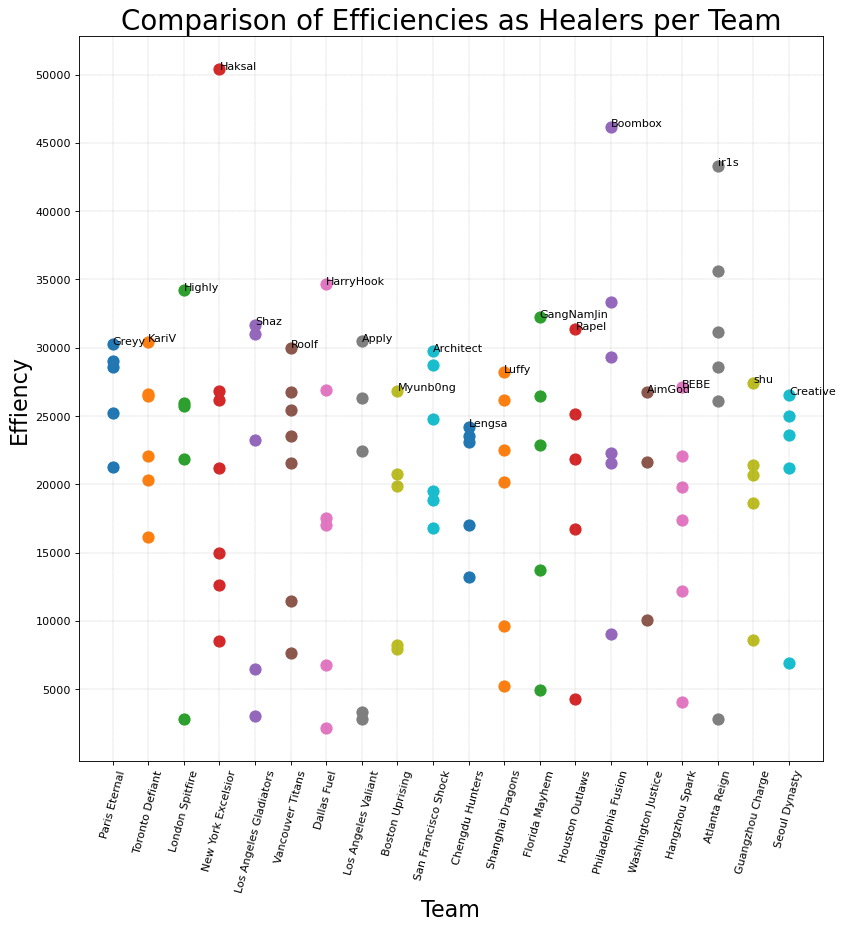

In [5]:
# Compare efficiencies of players playing as healers
tanks_table = average_table.loc[average_table['hero_name'].isin(healers)].copy()

# Define equation we will use to calculate overall efficiency and create efficiency column
def healer_efficiency(row):
    return (2*row['Assists'] + 1.5*row['Barrier Damage Done'] - 2*row['Deaths'] + 2*row['Eliminations'] + row['All Damage Done']
            + row['Final Blows'] + 2.5*row['Healing Done'] + 1.5*row['Objective Kills'] + row['Objective Time'] + 1.5*row['Ultimates Earned'])

tanks_table['Efficiency'] = tanks_table.apply(lambda row: healer_efficiency(row), axis=1)

# Ignore rows with less than 2000 efficiency as that probably means the player only played as the healer for less than a minute
# and drop newly irrelevant columns
tanks_table = tanks_table[tanks_table.Efficiency > 2000].groupby(['team_name', 'player_name']).mean()
tanks_table = tanks_table.reset_index()
best_effiency_table = tanks_table.loc[tanks_table.groupby('team_name')['Efficiency'].idxmax()]

# Plot efficiencies of each player for each team
plot = plt.figure(figsize=(12,12), dpi=80)
plots = plot.subplots()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.2)
for team in teams:
    plots.scatter(tanks_table.loc[tanks_table['team_name'] == team]['team_name'].tolist(), tanks_table.loc[tanks_table['team_name'] == team]['Efficiency'].tolist(), label=team, s=100)
for index, row in best_effiency_table.iterrows():
    plots.annotate(row['player_name'], (row['team_name'], row['Efficiency']))
plots.set_xticklabels(teams, rotation=75)
plots.set_xlabel('Team', fontsize=20)
plots.set_ylabel('Effiency', fontsize=20)
plots.set_yticks([5000,10000,15000,20000,25000,30000,35000,40000,45000,50000])
plots.set_title('Comparison of Efficiencies as Healers per Team', fontsize=25)
plt.show()

**Efficiencies for the players playing as tanks:**

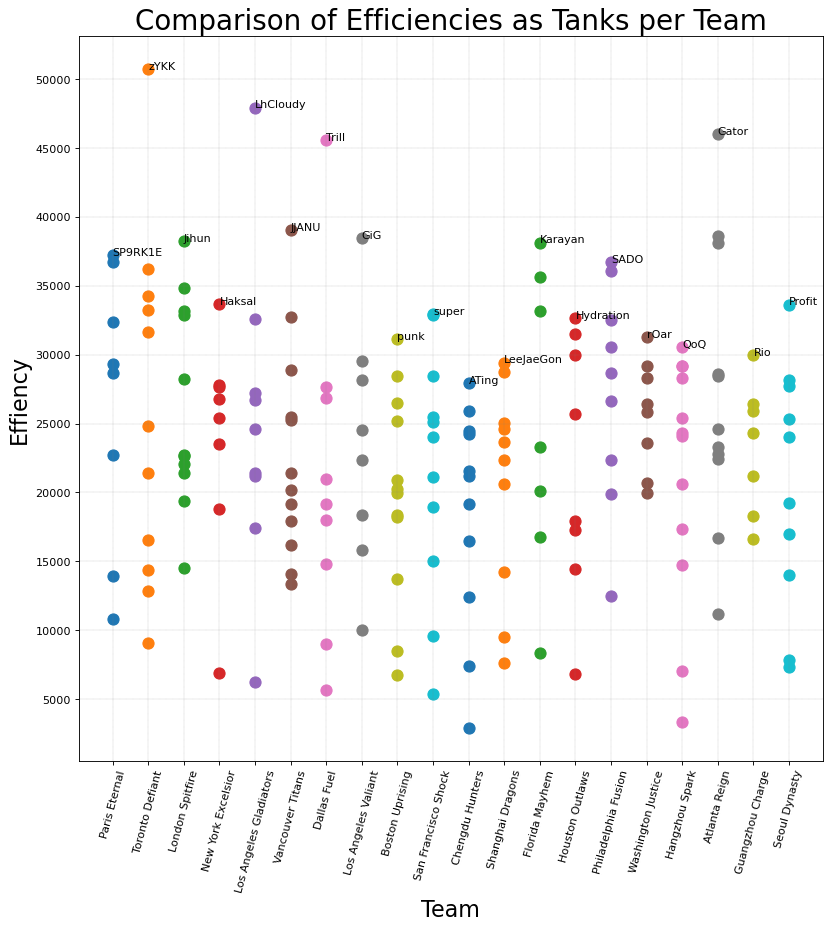

In [6]:
# Compare efficiencies of players playing as tanks
tanks_table = average_table.loc[average_table['hero_name'].isin(tanks)].copy()

# Define equation we will use to calculate overall efficiency
def tank_efficiency(row):
    return (1.5*row['Assists'] + row['Barrier Damage Done'] + 1.5*row['Damage Blocked'] - 2*row['Deaths'] + 2*row['Eliminations'] + row['All Damage Done']
            + row['Final Blows'] + 1.5*row['Healing Done'] + 1.5*row['Objective Kills'] + 2*row['Objective Time'] + row['Ultimates Earned'])

tanks_table['Efficiency'] = tanks_table.apply(lambda row: tank_efficiency(row), axis=1)

# Ignore rows with less than 2000 efficiency as that probably means the player only played as the healer for less than a minute
# and drop newly irrelevant columns
tanks_table = tanks_table[tanks_table.Efficiency > 2000].groupby(['team_name', 'player_name']).mean()
tanks_table = tanks_table.reset_index()
best_effiency_table = tanks_table.loc[tanks_table.groupby('team_name')['Efficiency'].idxmax()]

# Plot efficiencies of each player for each team
plot = plt.figure(figsize=(12,12), dpi=80)
plots = plot.subplots()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.2)
for team in teams:
    plots.scatter(tanks_table.loc[tanks_table['team_name'] == team]['team_name'].tolist(), tanks_table.loc[tanks_table['team_name'] == team]['Efficiency'].tolist(), label=team, s=100)
for index, row in best_effiency_table.iterrows():
    plots.annotate(row['player_name'], (row['team_name'], row['Efficiency']))
plots.set_xticklabels(teams, rotation=75)
plots.set_xlabel('Team', fontsize=20)
plots.set_ylabel('Effiency', fontsize=20)
plots.set_yticks([5000,10000,15000,20000,25000,30000,35000,40000,45000,50000])
plots.set_title('Comparison of Efficiencies as Tanks per Team', fontsize=25)
plt.show()